In [1]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 5.3 MB/s 
     |████████████████████████████████| 61 kB 418 kB/s 
     |████████████████████████████████| 596 kB 54.6 MB/s 
     |████████████████████████████████| 3.3 MB 52.5 MB/s 
     |████████████████████████████████| 895 kB 60.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
FREEZE = False

In [3]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import collections
import numpy as np
import gc
gc.collect()
import re
from nltk.corpus import stopwords
import copy
import torch

from torch.utils.data import TensorDataset,random_split
from transformers import BertTokenizer
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
import random
import time
from sklearn.metrics import classification_report,accuracy_score,f1_score



In [4]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Dataset Preprocessing

### FRENCH DATASET ANALYSIS

In [7]:
FRENCH_HOF = []
FRENCH_NOT = []

In [8]:
french_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/french_tweets-003.csv', error_bad_lines=False)
print(french_df_2019.shape)
french_df_2019 = french_df_2019.sample(frac=0.025)
print(french_df_2019.shape)
from sklearn.model_selection import train_test_split
french_df_2019, french_df_2019t = train_test_split(french_df_2019, test_size=0.2)

french_df_2019.reset_index(inplace=True)
french_df_2019t.reset_index(inplace=True)

print(french_df_2019.shape)
print(french_df_2019.head())
labels = collections.Counter(french_df_2019['label'])
FRENCH_HOF.append(labels[1])
FRENCH_NOT.append(labels[0])
print(labels)
print(french_df_2019.columns)
french_df_2019.head()

(199987, 2)
(5000, 2)
(4000, 3)
    index  label                                               text
0  163319      0  Je me demandais pourquoi vous changez votre av...
1  117002      0  Se sent vraiment malade et est au lit en écoutant
2  154473      0  Bummer à voir que vous ne pouvez pas faire - t...
3  178561      1  Oh mon ninja! Au moins, vous serez prêt pour l...
4   12605      0  Vous êtes comme une maman pour moi. (D'une man...
Counter({0: 3431, 1: 569})
Index(['index', 'label', 'text'], dtype='object')


,index,label,text
0,163319,0,Je me demandais pourquoi vous changez votre av...
1,117002,0,Se sent vraiment malade et est au lit en écoutant
2,154473,0,Bummer à voir que vous ne pouvez pas faire - t...
3,178561,1,"Oh mon ninja! Au moins, vous serez prêt pour l..."
4,12605,0,Vous êtes comme une maman pour moi. (D'une man...


In [9]:
print(french_df_2019t.shape)
print(french_df_2019t.head())
labels = collections.Counter(french_df_2019t['label'])
FRENCH_HOF.append(labels[1])
FRENCH_NOT.append(labels[0])
print(labels)
print(french_df_2019t.columns)
french_df_2019t.head()

(1000, 3)
    index  label                                               text
0  197663      1  Sherrie !!! Suivez-vous les garçons nkotb ici?...
1  197258      1  Hehe aime ce drapeau vert enthousiaste brandis...
2   27025      0                                Est un baiser total
3  162415      0            Je sais, j'ai marmonné désolé les gars!
4  186053      1  Il suffit de se réveiller, car à 11 ans je vai...
Counter({0: 845, 1: 155})
Index(['index', 'label', 'text'], dtype='object')


,index,label,text
0,197663,1,Sherrie !!! Suivez-vous les garçons nkotb ici?...
1,197258,1,Hehe aime ce drapeau vert enthousiaste brandis...
2,27025,0,Est un baiser total
3,162415,0,"Je sais, j'ai marmonné désolé les gars!"
4,186053,1,"Il suffit de se réveiller, car à 11 ans je vai..."


([<matplotlib.axis.XTick at 0x7f4185399810>,
 [Text(0, 0, 'train 2019'), Text(0, 0, 'test 2019')])

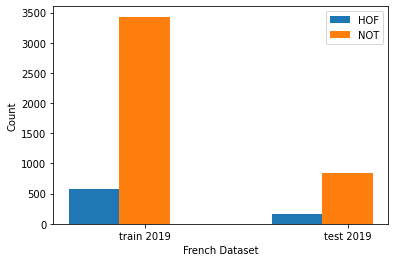

In [10]:
barWidth = 0.25
br1 = np.arange(len(FRENCH_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, FRENCH_HOF, width=barWidth, label='HOF')
plt.bar(br2, FRENCH_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('French Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2019', 'test 2019'])

###ENGLISH DATASET ANALYSIS

In [11]:
ENGLISH_HOF = []
ENGLISH_NOT = []

In [12]:
english_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/english_dataset/english_dataset_2019.csv', error_bad_lines=False)
english_df_2019 = english_df_2019.drop(columns=['task_2', 'task_3'])
print(english_df_2019.shape)
labels = collections.Counter(english_df_2019['task_1'])
ENGLISH_HOF.append(labels['HOF'])
ENGLISH_NOT.append(labels['NOT'])
print(labels)
print(english_df_2019.columns)
english_df_2019.head()

(5852, 3)
Counter({'NOT': 3591, 'HOF': 2261})
Index(['text_id', 'text', 'task_1'], dtype='object')


,text_id,text,task_1
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT


In [13]:
# english_df_2020 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/english_dataset/english_dataset_2020.csv', error_bad_lines=False)
# english_df_2020 = english_df_2020.drop(columns=['task2'])
# print(english_df_2020.shape)
# print(english_df_2020.columns)
# labels = collections.Counter(english_df_2020['task1'])
# ENGLISH_HOF.append(labels['HOF'])
# ENGLISH_NOT.append(labels['NOT'])
# print(labels)
# english_df_2020.head()

In [14]:
english_df_2019t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/english_dataset/english_dataset_test_2019.csv', error_bad_lines=False)
print(english_df_2019t.columns)
english_df_2019t = english_df_2019t.drop(columns=['task_2', 'task_3'])
print(english_df_2019t.shape)
labels = collections.Counter(english_df_2019t['task_1'])
ENGLISH_HOF.append(labels['HOF'])
ENGLISH_NOT.append(labels['NOT'])
print(labels)
english_df_2019t.head()

Index(['text_id', 'text', 'task_1', 'task_2', 'task_3'], dtype='object')
(1153, 3)
Counter({'NOT': 865, 'HOF': 288})


,text_id,text,task_1
0,hasoc_en_902,West Bengal Doctor Crisis: Protesting doctors ...,NOT
1,hasoc_en_416,68.5 million people have been forced to leave ...,NOT
2,hasoc_en_207,"You came, you saw .... we will look after the ...",NOT
3,hasoc_en_595,We'll get Brexit delivered by October 31st. ...,NOT
4,hasoc_en_568,Fuck you. Go back to the dark ages you cow @IB...,HOF


In [15]:
# english_df_2020t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/english_dataset/english_dataset_test_2020.csv', error_bad_lines=False)
# english_df_2020t = english_df_2020t.drop(columns=['task2'])
# print(english_df_2020t.shape)
# print(english_df_2020t.columns)
# labels = collections.Counter(english_df_2020t['task1'])
# ENGLISH_HOF.append(labels['HOF'])
# ENGLISH_NOT.append(labels['NOT'])
# print(labels)
# english_df_2020t.head()

([<matplotlib.axis.XTick at 0x7f4186101450>,
 [Text(0, 0, 'train 2019'), Text(0, 0, 'test 2019')])

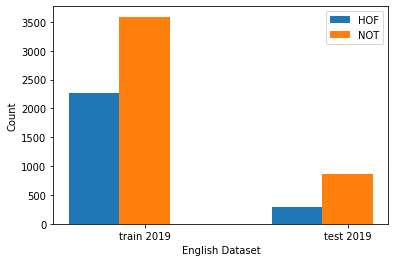

In [16]:
barWidth = 0.25
br1 = np.arange(len(ENGLISH_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, ENGLISH_HOF, width=barWidth, label='HOF')
plt.bar(br2, ENGLISH_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('English Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2019', 'test 2019'])

###SPANISH DATASET ANALYSIS

In [17]:
SPANISH_HOF = []
SPANISH_NOT = []

In [18]:
spanish_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/spanish_dataset/spanish_dataset.csv', error_bad_lines=False)
# spanish_df_2019 = spanish_df_2019.drop(columns=['task_2'])
print(spanish_df_2019.shape)
labels = collections.Counter(spanish_df_2019['HS'])
SPANISH_HOF.append(labels[1])
SPANISH_NOT.append(labels[0])
print(labels)
print(spanish_df_2019.columns)
spanish_df_2019.head()

(4450, 3)
Counter({0: 2617, 1: 1833})
Index(['id', 'text', 'HS'], dtype='object')


,id,text,HS
0,20001,Easyjet quiere duplicar el número de mujeres p...,1
1,20002,El gobierno debe crear un control estricto de ...,1
2,20003,Yo veo a mujeres destruidas por acoso laboral ...,0
3,20004,"— Yo soy respetuoso con los demás, sólamente l...",0
4,20007,Antonio Caballero y como ser de mal gusto e ig...,0


In [19]:
spanish_df_2019t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/spanish_dataset/spanish_dataset_test.csv', error_bad_lines=False)
# spanish_df_2019 = spanish_df_2019.drop(columns=['task_2'])
print(spanish_df_2019t.shape)
labels = collections.Counter(spanish_df_2019t['task_1'])
SPANISH_HOF.append(labels[1])
SPANISH_NOT.append(labels[0])
print(labels)
print(spanish_df_2019t.columns)
spanish_df_2019t.head()

(500, 3)
Counter({0: 278, 1: 222})
Index(['id', 'text', 'task_1'], dtype='object')


,id,text,task_1
0,20005,Me estoy comiendo la picada árabe más rica de ...,0
1,20006,@Haryachyzaychyk Callate zorra y mama duro! 😍,1
2,20011,Acabo de escuchar a Casado diciendo que hay DE...,0
3,20019,Y NADIE SE HA PREGUNTADO LO QUE LE VA A COSTAR...,1
4,20033,"@Fed_Durand Callate come sobra, más zorra son ...",1


([<matplotlib.axis.XTick at 0x7f41867786d0>,
 [Text(0, 0, 'train 2018'), Text(0, 0, 'test 2018')])

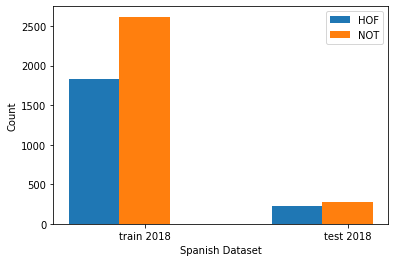

In [20]:
barWidth = 0.25
br1 = np.arange(len(SPANISH_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, SPANISH_HOF, width=barWidth, label='HOF')
plt.bar(br2, SPANISH_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('Spanish Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2018', 'test 2018'])

###GERMAN DATASET ANALYSIS

In [21]:
GERMAN_HOF = []
GERMAN_NOT = []

In [22]:
german_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/german_dataset/german_dataset_2019.csv', error_bad_lines=False)
german_df_2019 = german_df_2019.drop(columns=['task_2'])
print(german_df_2019.shape)
labels = collections.Counter(german_df_2019['task_1'])
GERMAN_HOF.append(labels['HOF'])
GERMAN_NOT.append(labels['NOT'])
print(labels)
print(german_df_2019.columns)
german_df_2019.head()

(3819, 3)
Counter({'NOT': 3412, 'HOF': 407})
Index(['text_id', 'text', 'task_1'], dtype='object')


,text_id,text,task_1
0,hasoc_de_1,Frank Rennicke – Ich bin stolz https://t.co/Cm...,NOT
1,hasoc_de_2,ANSEHEN.....und danach bitte TEILEN...TEILEN.....,NOT
2,hasoc_de_3,#Koeln Mohamed erkennt kein deutsches Recht so...,NOT
3,hasoc_de_4,#SaudiArabien ist eine brutale islamische Dikt...,NOT
4,hasoc_de_5,Bundespolizei #München hat im 1. Quartal 2019 ...,NOT


In [23]:
# german_df_2020 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/german_dataset/german_dataset_2020.csv', error_bad_lines=False)
# print(german_df_2020.columns)
# german_df_2020 = german_df_2020.drop(columns=['task2'])
# print(german_df_2020.shape)
# labels = collections.Counter(german_df_2020['task1'])
# GERMAN_HOF.append(labels['HOF'])
# GERMAN_NOT.append(labels['NOT'])
# print(labels)
# german_df_2020.head()

In [24]:
german_df_2019t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/german_dataset/german_dataset_test_2020.csv', error_bad_lines=False)
print(german_df_2019t.columns)
german_df_2019t = german_df_2019t.drop(columns=['task2'])
print(german_df_2019t.shape)
labels = collections.Counter(german_df_2019t['task1'])
GERMAN_HOF.append(labels['HOF'])
GERMAN_NOT.append(labels['NOT'])
print(labels)
german_df_2019t.head()

Index(['tweet_id', 'text', 'task1', 'task2', 'ID'], dtype='object')
(526, 4)
Counter({'NOT': 392, 'HOF': 134})


,tweet_id,text,task1,ID
0,1129095874242650112,@derCarsti Boykottieren hört sich besser an. 💙💙,NOT,hasoc_2020_de_1053
1,1129004308396236800,"RT @ibikus31: Es wird spekuliert, ob Merkel ei...",NOT,hasoc_2020_de_671
2,1130896929355907080,Hat #Hitler wirklich den Krieg in der Wüste ve...,NOT,hasoc_2020_de_2977
3,1132251534329307136,RT @Beatrix_vStorch: #May tritt in UK unter Tr...,NOT,hasoc_2020_de_1746
4,1124941869115498496,@justmeDoro Eher nicht. Das Gänse hauen wieder...,NOT,hasoc_2020_de_2416


In [25]:
# german_df_2020t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/english_dataset/english_dataset_test_2020.csv', error_bad_lines=False)
# german_df_2020t = german_df_2020t.drop(columns=['task2'])
# print(german_df_2020t.shape)
# print(german_df_2020t.columns)
# labels = collections.Counter(german_df_2020t['task1'])
# GERMAN_HOF.append(labels['HOF'])
# GERMAN_NOT.append(labels['NOT'])
# print(labels)
# german_df_2020t.head()

([<matplotlib.axis.XTick at 0x7f4185f89a90>,
 [Text(0, 0, 'train 2019'), Text(0, 0, 'test 2019')])

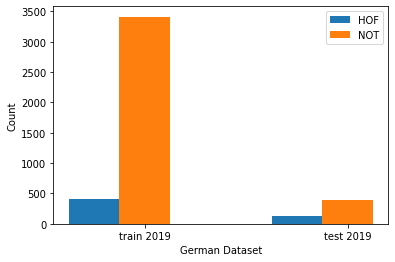

In [26]:
barWidth = 0.25
br1 = np.arange(len(GERMAN_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, GERMAN_HOF, width=barWidth, label='HOF')
plt.bar(br2, GERMAN_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('German Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2019', 'test 2019'])

###HINDI DATASET ANALYSIS

In [27]:
HINDI_HOF = []
HINDI_NOT = []

In [28]:
hindi_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/hindi_dataset/hindi_dataset_2019.csv', error_bad_lines=False)
hindi_df_2019 = hindi_df_2019.drop(columns=['task_2', 'task_3'])
print(hindi_df_2019.shape)
labels = collections.Counter(hindi_df_2019['task_1'])
HINDI_HOF.append(labels['HOF'])
HINDI_NOT.append(labels['NOT'])
print(labels)
print(hindi_df_2019.columns)
hindi_df_2019.head()

(4665, 3)
Counter({'HOF': 2469, 'NOT': 2196})
Index(['text_id', 'text', 'task_1'], dtype='object')


,text_id,text,task_1
0,hasoc_hi_5556,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",NOT
1,hasoc_hi_5648,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,HOF
2,hasoc_hi_164,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,HOF
3,hasoc_hi_3530,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",NOT
4,hasoc_hi_5206,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,NOT


In [29]:
# hindi_df_2020 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/hindi_dataset/hindi_dataset_2020.csv', error_bad_lines=False)
# print(hindi_df_2020.columns)
# hindi_df_2020 = hindi_df_2020.drop(columns=['task2'])
# print(hindi_df_2020.shape)
# labels = collections.Counter(hindi_df_2020['task1'])
# HINDI_HOF.append(labels['HOF'])
# HINDI_NOT.append(labels['NOT'])
# print(labels)
# hindi_df_2020.head()

In [30]:
hindi_df_2019t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/hindi_dataset/hindi_dataset_test_2020.csv', error_bad_lines=False)
print(hindi_df_2019t.columns)
hindi_df_2019t = hindi_df_2019t.drop(columns=['task2'])
print(hindi_df_2019t.shape)
labels = collections.Counter(hindi_df_2019t['task1'])
HINDI_HOF.append(labels['HOF'])
HINDI_NOT.append(labels['NOT'])
print(labels)
hindi_df_2019t.head()

Index(['tweet_id', 'text', 'task1', 'task2', 'ID'], dtype='object')
(663, 4)
Counter({'NOT': 466, 'HOF': 197})


,tweet_id,text,task1,ID
0,1127781647783301120,@Kinjal_Dubey_ इसके लिए तैयारी हो रखी है\nआपको...,HOF,hasoc_2020_hi_1938
1,1127492853171535872,RT @pratimamishra04: दिल्ली के मुख्यमंत्री @Ar...,NOT,hasoc_2020_hi_1201
2,1123638375896903681,"RT @nishantdabre2: आज एक तरफ खुशी है, तो एक तर...",NOT,hasoc_2020_hi_1628
3,1127496460310683648,@BJP4India @HardeepSPuri जिस कुनबे के लोग :-\n...,NOT,hasoc_2020_hi_3257
4,1127667277535399937,@manakgupta बादल....😂😂😂,NOT,hasoc_2020_hi_4133


In [31]:
# # hindi_df_2020t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/hindi_dataset/hindi_dataset_test_2020.csv', error_bad_lines=False)
# hindi_df_2020t = hindi_df_2020t.drop(columns=['task2'])
# print(hindi_df_2020t.shape)
# print(hindi_df_2020t.columns)
# labels = collections.Counter(hindi_df_2020t['task1'])
# HINDI_HOF.append(labels['HOF'])
# HINDI_NOT.append(labels['NOT'])
# print(labels)
# hindi_df_2020t.head()

([<matplotlib.axis.XTick at 0x7f4185c29e90>,
 [Text(0, 0, 'train 2019'), Text(0, 0, 'test 2019')])

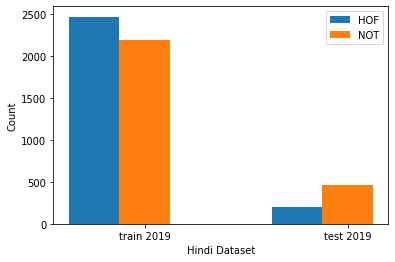

In [32]:
barWidth = 0.25
br1 = np.arange(len(HINDI_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, HINDI_HOF, width=barWidth, label='HOF')
plt.bar(br2, HINDI_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('Hindi Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2019', 'test 2019'])

###COLLECTIVE DATASET ANALYSIS

In [33]:
total_hof = [np.sum(ENGLISH_HOF), np.sum(GERMAN_HOF), np.sum(SPANISH_HOF), np.sum(HINDI_HOF), np.sum(FRENCH_HOF)]
total_not = [np.sum(ENGLISH_NOT), np.sum(GERMAN_NOT), np.sum(SPANISH_HOF), np.sum(HINDI_NOT), np.sum(FRENCH_NOT)]

Text(0.5, 1.0, 'Hate Tweets')

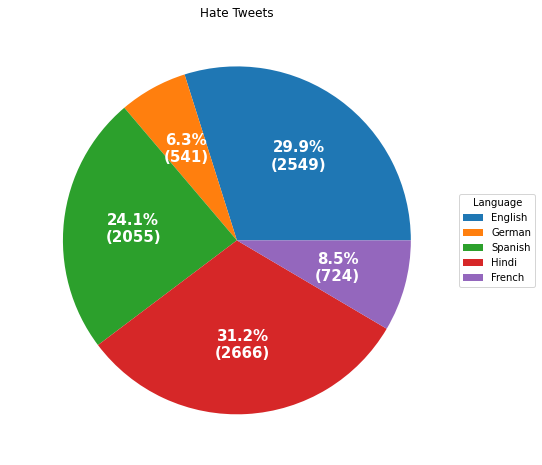

In [34]:
labels = ['English', 'German', 'Spanish', 'Hindi', 'French']
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(total_hof, autopct=lambda pct: func(pct, total_hof),textprops=dict(color="w"), labels=labels)
ax.legend(wedges, labels,
          title="Language",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold")
ax.set_title("Hate Tweets")

Text(0.5, 1.0, 'Not Hate Tweets')

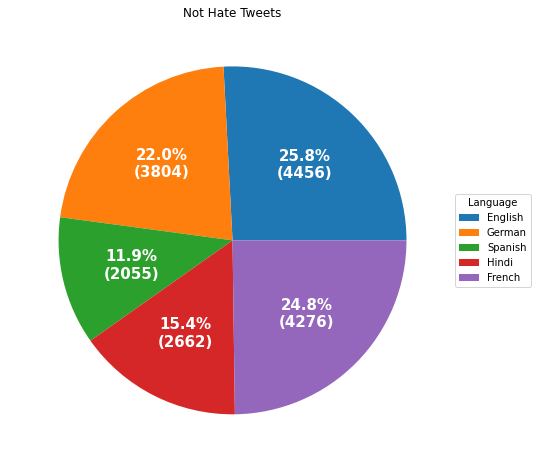

In [35]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(total_not, autopct=lambda pct: func(pct, total_not),textprops=dict(color="w"), labels=labels)
ax.legend(wedges, labels,
          title="Language",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold")
ax.set_title("Not Hate Tweets")

Text(0.5, 1.0, 'Language Distribution of Datasets')

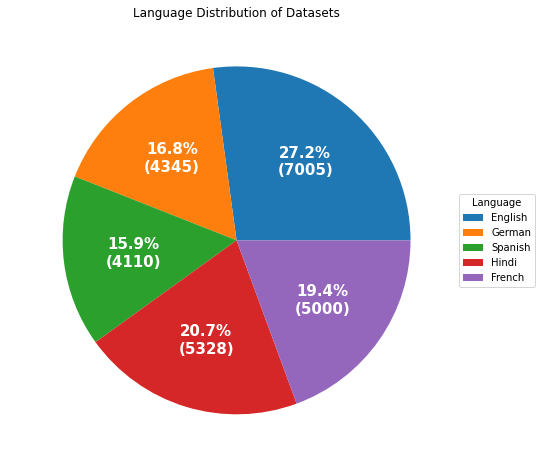

In [36]:
data = [a + b for a, b in zip(total_hof, total_not)]
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),textprops=dict(color="w"), labels=labels)
ax.legend(wedges, labels,
          title="Language",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold")
ax.set_title("Language Distribution of Datasets")

### CLEANING OF DATA - Remove STOP WORDS, tokens and twitter handles

In [37]:
def modify_tweets(data):
  # print(data.columns)
  modified_tweets = []
  for text in data:

      #To remove @AnyName from the tweets
      text=re.sub(r"@[a-zA-z0-9]*\s+","",text) 
      text=re.sub(r"@[a-zA-z0-9]*:","",text)
      text=re.sub(r"@[a-zA-z0-9]*","",text)  
      text=re.sub(r"@[a-zA-z0-9]*$","",text)
      
      #To remove links
      text=re.sub(r"^https://t.co/[a-zA-Z0-9]*\s+"," ",text)    
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s+"," ",text)  
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$"," ",text)    
      
      #To Convert all the tweets to low.
      # text=text.lower() 
      
      #To remove the shorthands
      text=re.sub(r"that's","that is ",text)
      text=re.sub(r"there's","there is ",text)
      text=re.sub(r"what's","what is ",text)
      text=re.sub(r"where's","where is ",text)
      text=re.sub(r"it's","it is ",text)
      text=re.sub(r"who's","who is ",text)
      text=re.sub(r"i'm","i am ",text)
      text=re.sub(r"she's","she is ",text)
      text=re.sub(r"he's","he is ",text)
      text=re.sub(r"they're","they are ",text)
      text=re.sub(r"who're","who are ",text)
      text=re.sub(r"ain't","am not ",text)
      text=re.sub(r"wouldn't","would not ",text)
      text=re.sub(r"shouldn't","should not ",text)
      text=re.sub(r"can't","cannot ",text)
      text=re.sub(r"couldn't","could not ",text)
      text=re.sub(r"won't","will not ",text)
      
      #To remove the single character
      text=re.sub(r"\s+[a-z]\s+"," ",text)
      text=re.sub(r"\s+[a-z]$"," ",text)
      text=re.sub(r"^[a-z]\s+"," ",text)
      
      #To remove non-word character
      text=re.sub(r"^[「人間はいわば感情に左右される生き物である」]*\s+"," ",text)
      text=re.sub(r"\s+[「人間はいわば感情に左右される生き物である」]*\s+"," ",text)
      text=re.sub(r"\s+[「人間はいわば感情に左右される生き物である」]*$"," ",text)
      text=re.sub(r"[!@$,%^&*\"><]*","",text)
      text=re.sub(r"\."," ",text)
      
      #To remove duplicate spaces
      text=re.sub(r"\s+"," ",text)
      
      #To remove digits 
      text=re.sub(r"\d"," ",text)
      
      #To remove non-word characters
      text=re.sub(r"\W"," ",text)
      
      modified_tweets.append(text)
  return modified_tweets

In [38]:
print(english_df_2019.head(1)['text'])
english_df_2019['text'] = modify_tweets(english_df_2019['text'])
print(english_df_2019.head(1)['text'])

print(english_df_2019t.head(1)['text'])
english_df_2019t['text'] = modify_tweets(english_df_2019t['text'])
print(english_df_2019t.head(1)['text'])

# print(english_df_2020.head(1)['text'])
# english_df_2020['text'] = modify_tweets(english_df_2020['text'])
# print(english_df_2020.head(1)['text'])

# print(english_df_2020t.head(1)['text'])
# english_df_2020t['text'] = modify_tweets(english_df_2020t['text'])
# print(english_df_2020t.head(1)['text'])

0    #DhoniKeepsTheGlove | WATCH: Sports Minister K...
Name: text, dtype: object
0     DhoniKeepsTheGlove   WATCH  Sports Minister K...
Name: text, dtype: object
0    West Bengal Doctor Crisis: Protesting doctors ...
Name: text, dtype: object
0    West Bengal Doctor Crisis  Protesting doctors ...
Name: text, dtype: object


In [39]:
print(german_df_2019.head(1)['text'])
german_df_2019['text'] = modify_tweets(german_df_2019['text'])
print(german_df_2019.head(1)['text'])

print(german_df_2019t.head(1)['text'])
german_df_2019t['text'] = modify_tweets(german_df_2019t['text'])
print(german_df_2019t.head(1)['text'])

# print(german_df_2020.head(1)['text'])
# german_df_2020['text'] = modify_tweets(german_df_2020['text'])
# print(german_df_2020.head(1)['text'])

# print(german_df_2020t.head(1)['text'])
# german_df_2020t['text'] = modify_tweets(german_df_2020t['text'])
# print(german_df_2020t.head(1)['text'])

0    Frank Rennicke – Ich bin stolz https://t.co/Cm...
Name: text, dtype: object
0    Frank Rennicke   Ich bin stolz 
Name: text, dtype: object
0    @derCarsti Boykottieren hört sich besser an. 💙💙
Name: text, dtype: object
0    Boykottieren hört sich besser an   
Name: text, dtype: object


In [40]:
print(spanish_df_2019.head(1)['text'])
spanish_df_2019['text'] = modify_tweets(spanish_df_2019['text'])
print(spanish_df_2019.head(1)['text'])

print(spanish_df_2019t.head(1)['text'])
spanish_df_2019t['text'] = modify_tweets(spanish_df_2019t['text'])
print(spanish_df_2019t.head(1)['text'])

0    Easyjet quiere duplicar el número de mujeres p...
Name: text, dtype: object
0    Easyjet quiere duplicar el número de mujeres p...
Name: text, dtype: object
0    Me estoy comiendo la picada árabe más rica de ...
Name: text, dtype: object
0    Me estoy comiendo la picada árabe más rica de ...
Name: text, dtype: object


In [41]:
def modify_hindi_tweets(data):
  # print(data.columns)
  modified_tweets = []
  for text in data:

      #To remove @AnyName from the tweets
      text=re.sub(r"@[a-zA-z0-9]*\s+","",text) 
      text=re.sub(r"@[a-zA-z0-9]*:","",text)
      text=re.sub(r"@[a-zA-z0-9]*","",text)  
      text=re.sub(r"@[a-zA-z0-9]*$","",text)
      
      #To remove links
      text=re.sub(r"^https://t.co/[a-zA-Z0-9]*\s+"," ",text)    
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s+"," ",text)  
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$"," ",text) 

      #To remove duplicate spaces
      text=re.sub(r"\s+"," ",text)
      
      #To remove digits 
      text=re.sub(r"\d"," ",text)
      
      #To remove non-word characters
      text=re.sub(r"\#"," ",text)
    
      modified_tweets.append(text)
  return modified_tweets

print(hindi_df_2019.head(1)['text'])
l = modify_hindi_tweets(hindi_df_2019['text'])
print(l[0])
hindi_df_2019['text'] = l
print(hindi_df_2019.head(1)['text'])

print(hindi_df_2019t.head(1)['text'])
hindi_df_2019t['text'] = modify_hindi_tweets(hindi_df_2019t['text'])
print(hindi_df_2019t.head(1)['text'])

# print(hindi_df_2020.head(1)['text'])
# hindi_df_2020['text'] = modify_hindi_tweets(hindi_df_2020['text'])
# print(hindi_df_2020.head(1)['text'])

# print(hindi_df_2020t.head(1)['text'])
# hindi_df_2020t['text'] = modify_hindi_tweets(hindi_df_2020t['text'])
# print(hindi_df_2020t.head(1)['text'])

0    बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...
Name: text, dtype: object
बांग्लादेश की शानदार वापसी, भारत को     रन पर रोका  INDvBAN  CWC  
0    बांग्लादेश की शानदार वापसी, भारत को     रन पर ...
Name: text, dtype: object
0    @Kinjal_Dubey_ इसके लिए तैयारी हो रखी है\nआपको...
Name: text, dtype: object
0    इसके लिए तैयारी हो रखी है आपको जान देने की जरू...
Name: text, dtype: object


### Utility functions



1. encoder_generator(documents)
2. predictions_labels(preds,labels)
3. categorical_accuracy(preds, y)
4. predictions_labels(preds,labels)
5. train(model, train_data_loader)
6. evaluate(model, valid_data_loader)
7. evaluate_test(model, test_data_loader)
8. epoch_time(start_time, end_time)
9. plot_vc(acc_train, acc_val)
10. plot_loss(loss_train, loss_val)



In [42]:
def encoder_generator(tokenizer, documents):
    
    doc_index = []
    input_ids = []
    attention_masks =[]

    for index,doc in enumerate(documents):
        
        doc_index.append(index)
        
        encoded_dict = tokenizer.encode_plus(doc,
                                             add_special_tokens=True,
                                             max_length=128,
                                             pad_to_max_length=True,
                                             truncation = True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    sent_index = torch.tensor(doc_index)

    return sent_index,input_ids,attention_masks


In [43]:
def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()

def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

In [44]:
def train(model, train_data_loader, optimizer):
    total_train_loss = 0
    total_train_acc = 0
    
    model.train() # set model in train mode for batchnorm and dropout layers in bert model
    
    for step,batch in enumerate(train_data_loader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
            
        output = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels.long())
        loss = output.loss
        logits = output.logits

        total_train_loss+=loss.item()
        total_train_acc+=categorical_accuracy(logits,b_labels).item()
            
        loss.backward()
            
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            
        optimizer.step()
            
        scheduler.step() #go ahead and update the learning rate
            
    avg_train_loss = total_train_loss/len(train_data_loader)
    avg_train_acc = total_train_acc/len(train_data_loader)
    
    return avg_train_loss,avg_train_acc

In [45]:
def evaluate(model, valid_data_loader):
    model.eval()
        
    total_eval_accuracy = 0
    total_eval_loss = 0
    number_of_eval_steps= 0
    
    all_true_labels = []
    all_pred_labels = []

    for batch in valid_data_loader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            output = model(b_input_ids,
                                attention_mask= b_input_mask,
                                labels = b_labels.long())
        loss = output.loss
        logits = output.logits

        total_eval_loss+=loss.item()

        logits = logits.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()

        pred,true = predictions_labels(logits,label_ids)
        
        all_pred_labels.extend(pred)
        all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    macro_f1_score = f1_score(all_pred_labels,all_true_labels,average='macro')
    
    avg_val_loss = total_eval_loss/len(valid_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
    
    return avg_val_loss,avg_val_accuracy,macro_f1_score

In [46]:
def evaluate_test(model, test_data_loader):
    model.eval()
        
    total_eval_accuracy = 0
    total_eval_loss = 0
    number_of_eval_steps= 0
    
    all_true_labels = []
    all_pred_labels = []
    
    all_sentence_id=[]

    for batch in test_data_loader:
        b_sentence_id = batch[0].to(device)
        b_input_ids = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)

        sent_ids = b_sentence_id.to('cpu').numpy()
        all_sentence_id.extend(sent_ids)
        
        with torch.no_grad():

            output = model(b_input_ids,
                                attention_mask= b_input_mask,
                                labels = b_labels.long())
            
        loss = output.loss
        logits = output.logits
        
        total_eval_loss+=loss.item()

        logits = logits.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()
        

        pred,true = predictions_labels(logits,label_ids)
        
        all_pred_labels.extend(pred)
        
        all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    
    avg_val_loss = total_eval_loss/len(test_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
    
    return avg_val_loss,avg_val_accuracy,all_sentence_id,all_pred_labels


In [47]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [48]:
def plot_vc(acc_train, acc_val):
  e = range(epochs)
  plt.plot(e, acc_train, 'g', label='Training Accuracy')
  plt.plot(e, acc_val, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [49]:
def plot_lc(loss_train, loss_val):
  e = range(epochs)
  plt.plot(e, loss_train, 'g', label='Training Loss')
  plt.plot(e, loss_val, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## Train English

### BERT BASED MODEL - TRAINED FOR ENGLISH 

In [50]:
train_data = english_df_2019.copy()
test_data = english_df_2019t.copy()
labels = {'HOF': 0, 'NOT': 1}

In [51]:
train_data['task_1'] = train_data['task_1'].apply(lambda x: labels[x])
test_data['task_1'] = test_data['task_1'].apply(lambda x: labels[x])

In [52]:
tokenizer_eng = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = 0
for sentence in train_data['text']:
    #print(sentence)
    length = len(tokenizer_eng.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index,input_ids,attention_masks = encoder_generator(tokenizer_eng, list(train_data['text']))
test_sent_index,test_input_ids,test_attention_masks = encoder_generator(tokenizer_eng, list(test_data['text']))
print('Original: ', train_data['text'][0])
print('Token IDs:', input_ids[0])

dataset = TensorDataset(input_ids,attention_masks,torch.tensor(train_data['task_1']))
test_dataset = TensorDataset(test_sent_index,test_input_ids,test_attention_masks,torch.tensor(test_data['task_1']))
train_size = int(0.8*len(dataset))
val_size = len(dataset)-train_size
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])
print('train data samples is {}'.format(len(train_dataset)))
print("valid data samples is {}".format(len(val_dataset)))
print("test data samples is {}".format(len(test_dataset)))

bs=8

train_data_loader_eng = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=bs)
valid_data_loader_eng = DataLoader(val_dataset,
                              sampler=SequentialSampler(val_dataset),
                              batch_size=bs)
test_data_loader_eng = DataLoader(test_dataset,
                            sampler=SequentialSampler(test_dataset),
                            batch_size=bs)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

max token length in train_data is:  85


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:   DhoniKeepsTheGlove   WATCH  Sports Minister Kiren Rijiju issues statement backing MS Dhoni over  Balidaan Badge  tells BCCI to take up the matter with ICC and keep government in the know as nation s pride is involved 
Token IDs: tensor([  101, 28144, 10698, 20553,  4523, 10760, 23296, 21818,  3422,  2998,
         2704, 11382,  7389, 15544,  4478,  9103,  3314,  4861,  5150,  5796,
        28144, 10698,  2058, 20222,  2850,  2319, 10780,  4136,  4647,  6895,
         2000,  2202,  2039,  1996,  3043,  2007, 16461,  1998,  2562,  2231,
         1999,  1996,  2113,  2004,  3842,  1055,  6620,  2003,  2920,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0, 

### Train BERT on ENGLISH

In [53]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                     num_labels=2,
                                                     output_attentions=False,
                                                     output_hidden_states=False,
                                                     )
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [54]:
if FREEZE:
  del model
  import gc
  gc.collect()

  model = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_bert-base-uncased.pt")
  model = model.to(device)

else:

  optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-8)

  epochs=10
  total_steps = len(train_data_loader_eng) * epochs

  scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

  total_t0 = time.time()

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  epochs = 10

  best_macro_f1 = float('0')

  train_acc_eng = []
  val_acc_eng = []
  train_loss_eng = []
  val_loss_eng = []

  for epoch in range(epochs):
      
      start_time = time.time()
      train_loss,train_acc = train(model, train_data_loader_eng, optimizer)
      valid_loss,valid_acc,macro_f1 = evaluate(model, valid_data_loader_eng)
      
      end_time = time.time()
          
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
          
      if macro_f1 > best_macro_f1:
          best_macro_f1 = macro_f1
          torch.save(model,'/content/gdrive/MyDrive/NLP Project/model_pt/model_english_bert-base-uncased.pt')
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      train_acc_eng.append(train_acc*100)
      val_acc_eng.append(valid_acc*100)
      train_loss_eng.append(train_loss*100)
      val_loss_eng.append(valid_loss*100)

              precision    recall  f1-score   support

           0       0.47      0.61      0.53       359
           1       0.80      0.70      0.75       812

    accuracy                           0.67      1171
   macro avg       0.64      0.65      0.64      1171
weighted avg       0.70      0.67      0.68      1171

accuracy = 0.67
Epoch: 01 | Epoch Time: 1m 18s
	Train Loss: 0.620 | Train Acc: 66.38%
	 Val. Loss: 0.608 |  Val. Acc: 66.95%
              precision    recall  f1-score   support

           0       0.56      0.61      0.58       424
           1       0.77      0.72      0.74       747

    accuracy                           0.68      1171
   macro avg       0.66      0.67      0.66      1171
weighted avg       0.69      0.68      0.69      1171

accuracy = 0.68
Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 0.514 | Train Acc: 75.68%
	 Val. Loss: 0.684 |  Val. Acc: 68.23%
              precision    recall  f1-score   support

           0       0.59      0.57      0.

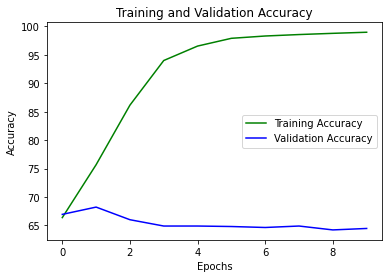

91.13267918088737
65.40563620836892


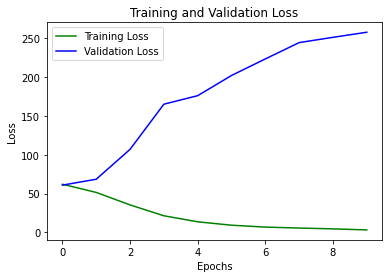

21.248263548375615
175.72111073684934


In [55]:
plot_vc(train_acc_eng, val_acc_eng)
print(np.mean(train_acc_eng))
print(np.mean(val_acc_eng))

plot_lc(train_loss_eng, val_loss_eng)
print(np.mean(train_loss_eng))
print(np.mean(val_loss_eng))

### Evaluate English

In [56]:
# if model:
#   del model
import gc
gc.collect()

model = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_bert-base-uncased.pt")
model = model.to(device)

valid_loss,valid_acc,all_sentence_id,all_pred_labels = evaluate_test(model, test_data_loader_eng)

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       296
           1       0.87      0.88      0.88       857

    accuracy                           0.81      1153
   macro avg       0.76      0.75      0.75      1153
weighted avg       0.81      0.81      0.81      1153

accuracy = 0.81


## Train French

###Load French Data

In [71]:
train_data_fr = french_df_2019.copy()
test_data_fr = french_df_2019t.copy()
# labels = {'HOF': 0, 'NOT': 1}

# train_data['HS'] = train_data['HS'].apply(lambda x: labels[x])
# test_data['task_1'] = test_data['task_1'].apply(lambda x: labels[x])

tokenizer_fr = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

max_length = 0
for sentence in train_data_fr['text']:
    #print(sentence)
    length = len(tokenizer_fr.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index_fr,input_ids_fr,attention_masks_fr = encoder_generator(tokenizer_fr, list(train_data_fr['text']))
test_sent_index_fr,test_input_ids_fr,test_attention_masks_fr = encoder_generator(tokenizer_fr, list(test_data_fr['text']))
# print('Original: ', train_data_fr['text'][0])
# print('Token IDs:', input_ids_fr[0])
dataset_fr = TensorDataset(input_ids_fr,attention_masks_fr,torch.tensor(train_data_fr['label']))
test_dataset_fr = TensorDataset(test_sent_index_fr,test_input_ids_fr,test_attention_masks_fr,torch.tensor(test_data_fr['label']))

train_size_fr = int(0.8*len(dataset_fr))

val_size_fr = len(dataset_fr)-train_size_fr

train_dataset_fr,val_dataset_fr = random_split(dataset_fr,[train_size_fr,val_size_fr])

print('train data samples is {}'.format(len(train_dataset_fr)))
print("valid data samples is {}".format(len(val_dataset_fr)))
print("test data samples is {}".format(len(test_dataset_fr)))

bs=8

train_data_loader_fr = DataLoader(train_dataset_fr,
                              sampler=RandomSampler(train_dataset_fr),
                              batch_size=bs)
valid_data_loader_fr = DataLoader(val_dataset_fr,
                              sampler=SequentialSampler(val_dataset_fr),
                              batch_size=bs)
test_data_loader_fr = DataLoader(test_dataset_fr,
                            sampler=SequentialSampler(test_dataset_fr),
                            batch_size=bs)


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

max token length in train_data is:  91


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


train data samples is 3200
valid data samples is 800
test data samples is 1000


### Evaluate BERT(English) on French Val Data

Bert trained on English and evaluated

In [72]:
# if model_fr:
#   del model_fr
import gc
gc.collect()

model_fr = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_task_a.pt")
model_fr = model_fr.to(device)

valid_loss_fr,valid_acc_fr,all_sentence_id_fr,all_pred_labels_fr = evaluate_test(model_fr, test_data_loader_fr)

              precision    recall  f1-score   support

           0       0.28      0.87      0.42       270
           1       0.78      0.18      0.29       730

    accuracy                           0.36      1000
   macro avg       0.53      0.52      0.36      1000
weighted avg       0.65      0.36      0.32      1000

accuracy = 0.36


### Train Fine tuned BERT (English) for French


In [73]:
# if model_eng:
#   del model_eng

if not FREEZE:

  import gc
  gc.collect()

  model_eng = torch.load('/content/gdrive/MyDrive/NLP Project/model_pt/model_english_task_a.pt')
  model_eng = model_eng.to(device)

  optimizer_fr = AdamW(model_eng.parameters(),lr=2e-5,eps=1e-8)

  epochs=10
  total_steps = len(train_data_loader_fr) * epochs

  scheduler = get_linear_schedule_with_warmup(optimizer_fr,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

  total_t0 = time.time()

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  epochs = 10

  best_macro_f1 = float('0')
  train_acc_eng_fr = []
  val_acc_eng_fr = []
  train_loss_eng_fr = []
  val_loss_eng_fr = []

  for epoch in range(epochs):
      
      start_time = time.time()
      train_loss,train_acc = train(model_eng, train_data_loader_fr, optimizer_fr)
      valid_loss,valid_acc,macro_f1 = evaluate(model_eng, valid_data_loader_fr)
      
      end_time = time.time()
          
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
          
      if macro_f1 > best_macro_f1:
          best_macro_f1 = macro_f1
          torch.save(model_eng,"/content/gdrive/MyDrive/NLP Project/model_pt/model_english_french_task_a.pt")
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      train_acc_eng_fr.append(train_acc*100)
      val_acc_eng_fr.append(valid_acc*100)
      train_loss_eng_fr.append(train_loss*100)
      val_loss_eng_fr.append(valid_loss*100)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       799
           1       0.01      1.00      0.02         1

    accuracy                           0.86       800
   macro avg       0.50      0.93      0.47       800
weighted avg       1.00      0.86      0.92       800

accuracy = 0.86
Epoch: 01 | Epoch Time: 0m 58s
	Train Loss: 0.404 | Train Acc: 85.91%
	 Val. Loss: 0.399 |  Val. Acc: 85.62%
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       756
           1       0.18      0.48      0.26        44

    accuracy                           0.85       800
   macro avg       0.57      0.68      0.59       800
weighted avg       0.92      0.85      0.88       800

accuracy = 0.85
Epoch: 02 | Epoch Time: 0m 58s
	Train Loss: 0.359 | Train Acc: 88.22%
	 Val. Loss: 0.485 |  Val. Acc: 85.25%
              precision    recall  f1-score   support

           0       0.99      0.87      0.

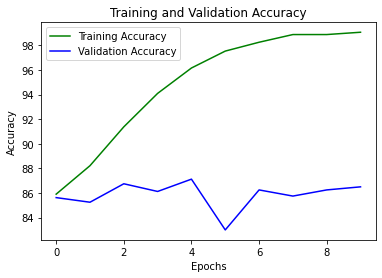

94.834375
85.8625


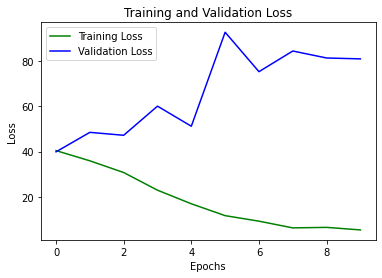

18.646710224397246
66.1588559538126


In [74]:
if not FREEZE:
  plot_vc(train_acc_eng_fr, val_acc_eng_fr)
  print(np.mean(train_acc_eng_fr))
  print(np.mean(val_acc_eng_fr))

  plot_lc(train_loss_eng_fr, val_loss_eng_fr)
  print(np.mean(train_loss_eng_fr))
  print(np.mean(val_loss_eng_fr))

###Evaluate BERT Eng-> French

In [75]:
# if model_fr:
#   del model_fr
import gc
gc.collect()

model_fr = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_french_task_a.pt")
model_fr = model_fr.to(device)

valid_loss_fr,valid_acc_fr,all_sentence_id_fr,all_pred_labels_fr = evaluate_test(model_fr, test_data_loader_fr)

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       906
           1       0.31      0.54      0.39        94

    accuracy                           0.84      1000
   macro avg       0.63      0.71      0.65      1000
weighted avg       0.89      0.84      0.86      1000

accuracy = 0.84


## Train Spanish

###Load Spanish Data

In [51]:
train_data_sp = spanish_df_2019.copy()
test_data_sp = spanish_df_2019t.copy()
labels = {'HOF': 0, 'NOT': 1}

# train_data['HS'] = train_data['HS'].apply(lambda x: labels[x])
# test_data['task_1'] = test_data['task_1'].apply(lambda x: labels[x])

tokenizer_sp = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

max_length = 0
for sentence in train_data_sp['text']:
    #print(sentence)
    length = len(tokenizer_sp.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index_sp,input_ids_sp,attention_masks_sp = encoder_generator(tokenizer_sp, list(train_data_sp['text']))
test_sent_index_sp,test_input_ids_sp,test_attention_masks_sp = encoder_generator(tokenizer_sp, list(test_data_sp['text']))
print('Original: ', train_data_sp['text'][0])
print('Token IDs:', input_ids_sp[0])
dataset_sp = TensorDataset(input_ids_sp,attention_masks_sp,torch.tensor(train_data_sp['HS']))
test_dataset_sp = TensorDataset(test_sent_index_sp,test_input_ids_sp,test_attention_masks_sp,torch.tensor(test_data_sp['task_1']))

train_size_sp = int(0.8*len(dataset_sp))

val_size_sp = len(dataset_sp)-train_size_sp

train_dataset_sp,val_dataset_sp = random_split(dataset_sp,[train_size_sp,val_size_sp])

print('train data samples is {}'.format(len(train_dataset_sp)))
print("valid data samples is {}".format(len(val_dataset_sp)))
print("test data samples is {}".format(len(test_dataset_sp)))

bs=8

train_data_loader_sp = DataLoader(train_dataset_sp,
                              sampler=RandomSampler(train_dataset_sp),
                              batch_size=bs)
valid_data_loader_sp = DataLoader(val_dataset_sp,
                              sampler=SequentialSampler(val_dataset_sp),
                              batch_size=bs)
test_data_loader_sp = DataLoader(test_dataset_sp,
                            sampler=SequentialSampler(test_dataset_sp),
                            batch_size=bs)


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

max token length in train_data is:  1229


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Easyjet quiere duplicar el número de mujeres piloto  Verás tú para aparcar el avión http   t co   NuLkm  x
Token IDs: tensor([  101, 39878, 18533, 68448, 10168, 62932, 15983, 10125, 13197, 10104,
        22354, 35635, 41357, 12299, 85777, 10220, 32500, 22549, 10129, 10125,
        48537, 10556,   188, 11170, 28336, 11369, 23440,   192,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0

### Evaluate BERT(English) on Spanish Val Data

Bert trained on English and evaluated

In [52]:
# if model_sp:
#   del model_sp
import gc
gc.collect()

model_sp = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_task_a.pt")
model_sp = model_sp.to(device)

valid_loss_sp,valid_acc_sp,all_sentence_id_sp,all_pred_labels_sp = evaluate_test(model_sp, test_data_loader_sp)

              precision    recall  f1-score   support

           0       0.49      0.51      0.50       269
           1       0.40      0.39      0.39       231

    accuracy                           0.45       500
   macro avg       0.45      0.45      0.45       500
weighted avg       0.45      0.45      0.45       500

accuracy = 0.45


### Train Fine tuned BERT (English) for Spanish


In [53]:
# if model_eng:
#   del model_eng

if not FREEZE:
  import gc
  gc.collect()

  model_eng = torch.load('/content/gdrive/MyDrive/NLP Project/model_pt/model_english_task_a.pt')
  model_eng = model_eng.to(device)

  optimizer_sp = AdamW(model_eng.parameters(),lr=2e-5,eps=1e-8)

  epochs=10
  total_steps = len(train_data_loader_sp) * epochs

  scheduler = get_linear_schedule_with_warmup(optimizer_sp,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

  total_t0 = time.time()

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  epochs = 10

  best_macro_f1 = float('0')
  train_acc_eng_sp = []
  val_acc_eng_sp = []
  train_loss_eng_sp = []
  val_loss_eng_sp = []

  for epoch in range(epochs):
      
      start_time = time.time()
      train_loss,train_acc = train(model_eng, train_data_loader_sp, optimizer_sp)
      valid_loss,valid_acc,macro_f1 = evaluate(model_eng, valid_data_loader_sp)
      
      end_time = time.time()
          
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
          
      if macro_f1 > best_macro_f1:
          best_macro_f1 = macro_f1
          torch.save(model_eng,"/content/gdrive/MyDrive/NLP Project/model_pt/model_english_spanish_task_a.pt")
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      train_acc_eng_sp.append(train_acc*100)
      val_acc_eng_sp.append(valid_acc*100)
      train_loss_eng_sp.append(train_loss*100)
      val_loss_eng_sp.append(valid_loss*100)

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       585
           1       0.65      0.72      0.69       305

    accuracy                           0.77       890
   macro avg       0.75      0.76      0.75       890
weighted avg       0.78      0.77      0.77       890

accuracy = 0.77
Epoch: 01 | Epoch Time: 1m 5s
	Train Loss: 0.578 | Train Acc: 70.81%
	 Val. Loss: 0.503 |  Val. Acc: 77.19%
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       483
           1       0.80      0.67      0.73       407

    accuracy                           0.77       890
   macro avg       0.78      0.77      0.77       890
weighted avg       0.78      0.77      0.77       890

accuracy = 0.77
Epoch: 02 | Epoch Time: 1m 5s
	Train Loss: 0.416 | Train Acc: 82.28%
	 Val. Loss: 0.595 |  Val. Acc: 77.42%
              precision    recall  f1-score   support

           0       0.82      0.86      0.84

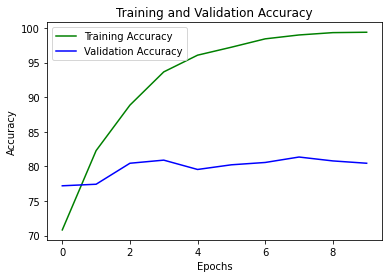

92.5
79.8876404494382


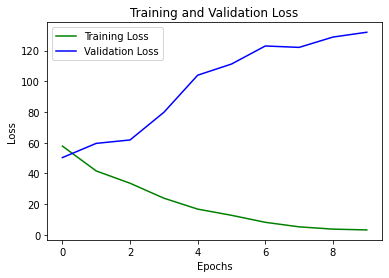

20.610118387955023
97.24335172834148


In [54]:
if not FREEZE:
  plot_vc(train_acc_eng_sp, val_acc_eng_sp)
  print(np.mean(train_acc_eng_sp))
  print(np.mean(val_acc_eng_sp))

  plot_lc(train_loss_eng_sp, val_loss_eng_sp)
  print(np.mean(train_loss_eng_sp))
  print(np.mean(val_loss_eng_sp))

###Evaluate BERT Eng-> Span

In [55]:
# if model_sp:
#   del model_sp
import gc
gc.collect()

model_sp = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_spanish_task_a.pt")
model_sp = model_sp.to(device)

valid_loss_sp,valid_acc_sp,all_sentence_id_sp,all_pred_labels_sp = evaluate_test(model_sp, test_data_loader_sp)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       263
           1       0.77      0.72      0.74       237

    accuracy                           0.76       500
   macro avg       0.76      0.76      0.76       500
weighted avg       0.76      0.76      0.76       500

accuracy = 0.76


##Train German

### Load German data

In [56]:
train_data_ger = german_df_2019.copy()
test_data_ger = german_df_2019t.copy()
labels = {'HOF': 0, 'NOT': 1}

train_data_ger['task_1'] = train_data_ger['task_1'].apply(lambda x: labels[x])
test_data_ger['task1'] = test_data_ger['task1'].apply(lambda x: labels[x])

tokenizer_ger = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

max_length = 0
for sentence in train_data_ger['text']:
    #print(sentence)
    length = len(tokenizer_ger.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index_ger,input_ids_ger,attention_masks_ger = encoder_generator(tokenizer_ger, list(train_data_ger['text']))
test_sent_index_ger,test_input_ids_ger,test_attention_masks_ger = encoder_generator(tokenizer_ger, list(test_data_ger['text']))
print('Original: ', train_data_ger['text'][0])
print('Token IDs:', input_ids_ger[0])
dataset_ger = TensorDataset(input_ids_ger,attention_masks_ger,torch.tensor(train_data_ger['task_1']))
test_dataset_ger = TensorDataset(test_sent_index_ger,test_input_ids_ger,test_attention_masks_ger,torch.tensor(test_data_ger['task1']))

train_size_ger = int(0.8*len(dataset_ger))

val_size_ger = len(dataset_ger)-train_size_ger

train_dataset_ger,val_dataset_ger = random_split(dataset_ger,[train_size_ger,val_size_ger])

print('train data samples is {}'.format(len(train_dataset_ger)))
print("valid data samples is {}".format(len(val_dataset_ger)))
print("test data samples is {}".format(len(test_dataset_ger)))

bs=8

train_data_loader_ger = DataLoader(train_dataset_ger,
                              sampler=RandomSampler(train_dataset_ger),
                              batch_size=bs)
valid_data_loader_ger = DataLoader(val_dataset_ger,
                              sampler=SequentialSampler(val_dataset_ger),
                              batch_size=bs)
test_data_loader_ger = DataLoader(test_dataset_ger,
                            sampler=SequentialSampler(test_dataset_ger),
                            batch_size=bs)


max token length in train_data is:  132


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Frank Rennicke   Ich bin stolz 
Token IDs: tensor([  101, 11872, 52712, 71609, 10112, 21023, 16292, 47264, 48275,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

### Evaluate BERT(English) on German Val Data

Bert trained on English and evaluated

In [57]:
# if model_ger:
#   del model_ger
import gc
gc.collect()

model_ger = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_task_a.pt")
model_ger = model_ger.to(device)

valid_loss_ger,valid_acc_ger,all_sentence_id_ger,all_pred_labels_ger = evaluate_test(model_ger, test_data_loader_ger)

              precision    recall  f1-score   support

           0       0.56      0.43      0.49       175
           1       0.74      0.83      0.79       351

    accuracy                           0.70       526
   macro avg       0.65      0.63      0.64       526
weighted avg       0.68      0.70      0.69       526

accuracy = 0.70


###Train Fine tuned BERT (English) for German

In [58]:
# if model_eng:
#   del model_eng

if not FREEZE:

  import gc
  gc.collect()

  model_eng = torch.load('/content/gdrive/MyDrive/NLP Project/model_pt/model_english_task_a.pt')
  model_eng = model_eng.to(device)

  optimizer_ger = AdamW(model_eng.parameters(),lr=2e-5,eps=1e-8)

  epochs=10
  total_steps = len(train_data_loader_ger) * epochs

  scheduler = get_linear_schedule_with_warmup(optimizer_ger,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

  total_t0 = time.time()

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  epochs = 10

  best_macro_f1 = float('0')
  train_acc_eng_ger = []
  val_acc_eng_ger = []
  train_loss_eng_ger=[]
  val_loss_eng_ger=[]

  for epoch in range(epochs):
      
      start_time = time.time()
      train_loss,train_acc = train(model_eng, train_data_loader_ger, optimizer_ger)
      valid_loss,valid_acc,macro_f1 = evaluate(model_eng, valid_data_loader_ger)
      
      end_time = time.time()
          
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
          
      if macro_f1 > best_macro_f1:
          best_macro_f1 = macro_f1
          torch.save(model_eng,"/content/gdrive/MyDrive/NLP Project/model_pt/model_english_german_task_a.pt")
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      train_acc_eng_ger.append(train_acc*100)
      val_acc_eng_ger.append(valid_acc*100)
      train_loss_eng_ger.append(train_loss*100)
      val_loss_eng_ger.append(valid_loss*100)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 01 | Epoch Time: 0m 56s
	Train Loss: 0.357 | Train Acc: 89.10%
	 Val. Loss: 0.330 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 02 | Epoch Time: 0m 56s
	Train Loss: 0.349 | Train Acc: 89.17%
	 Val. Loss: 0.350 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 03 | Epoch Time: 0m 56s
	Train Loss: 0.351 | Train Acc: 89.17%
	 Val. Loss: 0.346 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 04 | Epoch Time: 0m 56s
	Train Loss: 0.352 | Train Acc: 89.16%
	 Val. Loss: 0.338 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 05 | Epoch Time: 0m 56s
	Train Loss: 0.346 | Train Acc: 89.17%
	 Val. Loss: 0.329 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 06 | Epoch Time: 0m 56s
	Train Loss: 0.347 | Train Acc: 89.17%
	 Val. Loss: 0.329 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 07 | Epoch Time: 0m 56s
	Train Loss: 0.348 | Train Acc: 89.17%
	 Val. Loss: 0.329 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 08 | Epoch Time: 0m 56s
	Train Loss: 0.346 | Train Acc: 89.16%
	 Val. Loss: 0.329 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 09 | Epoch Time: 0m 56s
	Train Loss: 0.346 | Train Acc: 89.16%
	 Val. Loss: 0.329 |  Val. Acc: 90.05%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 10 | Epoch Time: 0m 56s
	Train Loss: 0.346 | Train Acc: 89.16%
	 Val. Loss: 0.329 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


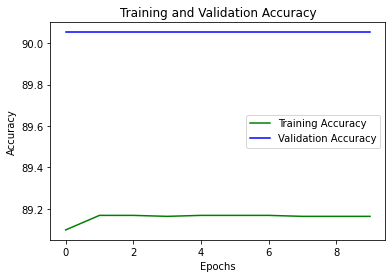

89.15996634367248
90.0523560209424


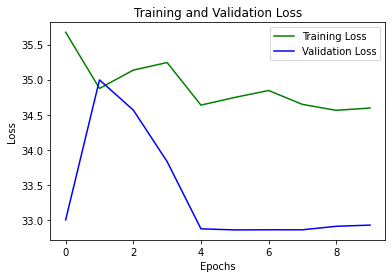

34.89639653599972
33.366165184415884


In [59]:
if not FREEZE:
  plot_vc(train_acc_eng_ger, val_acc_eng_ger)
  print(np.mean(train_acc_eng_ger))
  print(np.mean(val_acc_eng_ger))

  plot_lc(train_loss_eng_ger, val_loss_eng_ger)
  print(np.mean(train_loss_eng_ger))
  print(np.mean(val_loss_eng_ger))

###Evaluate BERT Eng->GER

In [60]:
# if model_ger:
#   del model_ger
import gc
gc.collect()

model_ger = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_english_german_task_a.pt")
model_ger = model_ger.to(device)

valid_loss_ger,valid_acc_ger,all_sentence_id_ger,all_pred_labels_ger = evaluate_test(model_ger, test_data_loader_ger)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.75      0.85       526

    accuracy                           0.75       526
   macro avg       0.50      0.37      0.43       526
weighted avg       1.00      0.75      0.85       526

accuracy = 0.75


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TODO



*   Plot loss curve instead of accuracy curve [DONE]
*   Verify the code flow and variable names [DONE]

---

*   Data Augmentation [TBD]




